In [1]:
import os
os.environ['FILEREADER_CACHE'] = '1'

from openpilot.tools.lib.logreader import LogReader

ROUTE = 'e886087f430e7fe7/2024-02-06--23-45-19/18:33'

events = list(LogReader(ROUTE))

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /mnt/c/Users/camer/AppData/Local/Programs/Microsoft VS Code


In [2]:
from cereal import car
from opendbc.can.parser import CANParser

EventName = car.CarEvent.EventName

# openpilot's vEgo is lower than the car's reported speed... we need to figure out the factor to multiply by
# so that openpilot can match the displayed speed

# - carState.cruiseState.enabled is True when the car is in cruise control
# - carState.vEgo is the speed openpilot is using
# - carState.cruiseState.speed is the speed the car is displaying

# Iterating through the logs
# - when enabled goes high, wait for N seconds to wait for the speed to settle
# - when the speed setting changes, wait for N seconds to wait for the speed to settle
# - once the time has passed, start recording the logs

MI_TO_KM = 1.609344
KM_TO_MI = 1 / MI_TO_KM
MS_TO_KPH = 3.6
KPH_TO_MS = 1 / MS_TO_KPH
MS_TO_MPH = MS_TO_KPH * KM_TO_MI

# (carState.vEgo, carState.cruiseState.speed)
points = []

# The time to wait for the speed to settle
start_time = 0

brk_speed = None
eng_speed = None
filtered_speed = None

last_enabled = False
last_cruise_speed = None

print(len(events))

dbc = 'ford_lincoln_base_pt'
msgs = [('BrakeSysFeatures', 0), ('EngVehicleSpThrottle2', 0)]
parser = CANParser(dbc, msgs, 0)

for event in events:
  time = event.logMonoTime / 1e9

  if event.which() == 'longitudinalPlan':
    LP = event.longitudinalPlan
    if LP.hasLead or LP.longitudinalPlanSource != 0:
      # delay starting until the lead car is gone
      print("lead car")
      start_time = max(start_time, time + 1)
    continue

  if event.which() == 'can':
    can_strings = [event.as_builder().to_bytes()]
    parser.update_strings(can_strings)
    brk_speed = parser.vl['BrakeSysFeatures']['Veh_V_ActlBrk'] * KPH_TO_MS
    eng_speed = parser.vl['EngVehicleSpThrottle2']['Veh_V_ActlEng'] * KPH_TO_MS

  if event.which() != 'carState':
    continue

  CS = event.carState
  filtered_speed = CS.vEgo
  enabled = CS.cruiseState.enabled
  cruise_speed = round(CS.cruiseState.speed * MS_TO_MPH) / MS_TO_MPH

  for carEvent in CS.events:
    if carEvent.name in (EventName.driverDistracted, EventName.driverUnresponsive):
      # delay starting until not distracted
      print("distracted")
      start_time = max(start_time, time + 1)
    if carEvent.name in (EventName.gasPressedOverride, ):
      # delay starting until not pressing gas
      print("gas pressed")
      start_time = max(start_time, time + 1)

  if enabled != last_enabled:
    last_enabled = enabled
    start_time = max(start_time, time + 7)
  if cruise_speed != last_cruise_speed:
    last_cruise_speed = cruise_speed
    start_time = max(start_time, time + 8)

  if time < start_time:
    continue

  if enabled and cruise_speed and (brk_speed > 0 or eng_speed > 0 or filtered_speed > 0):
    points.append((cruise_speed, brk_speed, eng_speed, filtered_speed))

len(points)

1040110
lead car
lead car
lead car
lead car
lead car
lead car
lead car
lead car
lead car
lead car
lead car
lead car
lead car
lead car
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distracted
distract

31052

In [3]:
import pandas as pd

df = pd.DataFrame(points, columns=['cruise', 'ABS', 'PCM', 'vEgo'])
df

,cruise,ABS,PCM,vEgo
0,33.5280,32.169444,32.122222,32.137020
1,33.5280,32.169444,32.122222,32.143066
2,33.5280,32.152778,32.125000,32.145702
3,33.5280,32.152778,32.125000,32.148037
4,33.5280,32.130556,32.136111,32.146217
...,...,...,...,...
31047,13.4112,12.708333,12.727778,12.725838
31048,13.4112,12.691667,12.727778,12.719935
31049,13.4112,12.691667,12.722222,12.714493
31050,13.4112,12.705556,12.722222,12.711946


<Axes: >

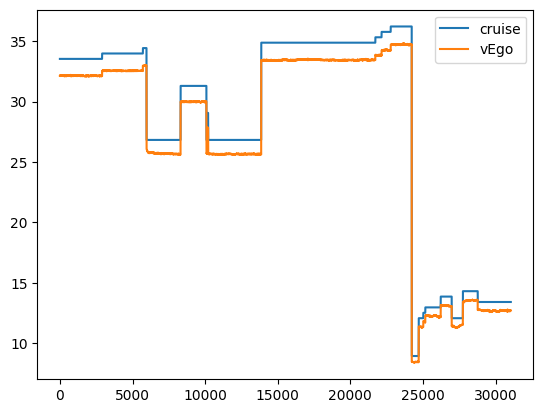

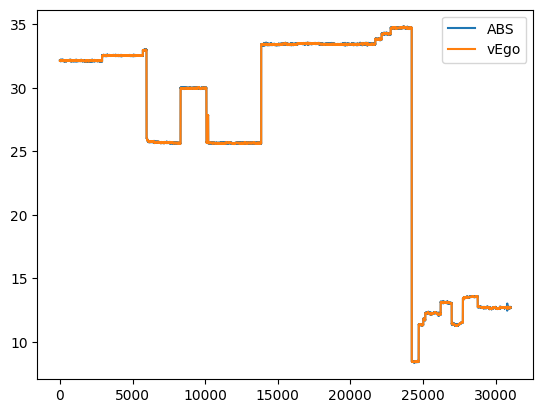

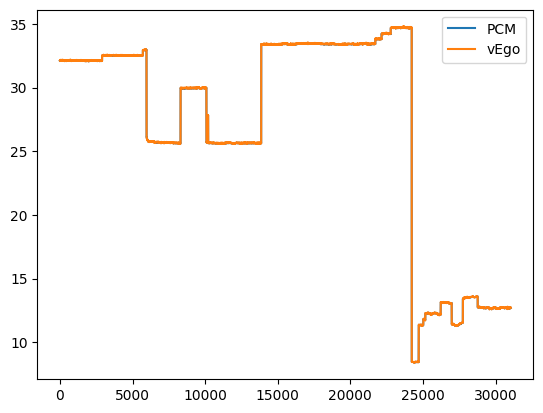

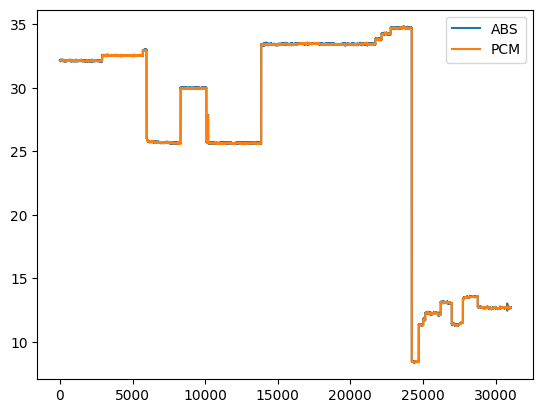

In [4]:
df[['cruise', 'vEgo']].plot()
df[['ABS', 'vEgo']].plot()
df[['PCM', 'vEgo']].plot()
df[['ABS', 'PCM']].plot()

<Axes: >

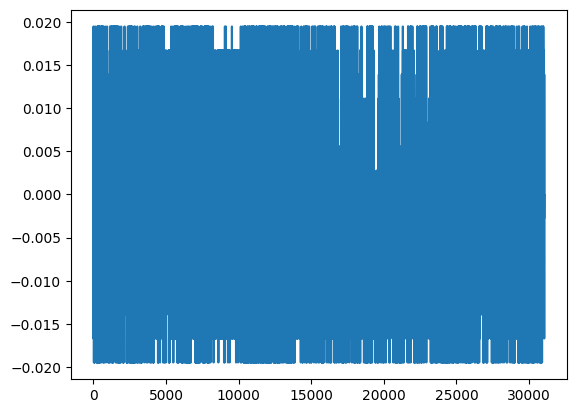

In [7]:
df_crop = pd.DataFrame(points, columns=['cruise', 'ABS', 'PCM', 'vEgo'])
df_crop['derivative'] = df_crop['ABS'].diff()
# df['derivative'].plot()
df_crop = df_crop[(df_crop['derivative'] > -.02) & (df_crop['derivative'] < .02)]
df_crop['derivative'].plot()

ABS
fit_ABS = 1.0348909455515425 * ABS^1 + 0.27435392409430825
mean absolute error: 0.03442534187787169 against cruise speed

PCM
fit_PCM = 1.0351044324096297 * PCM^1 + 0.2758852339141292
mean absolute error: 0.028902797396114087 against cruise speed

vEgo
fit_vEgo = 1.0348898286922794 * vEgo^1 + 0.27440221314475877
mean absolute error: 0.031037188784646397 against cruise speed



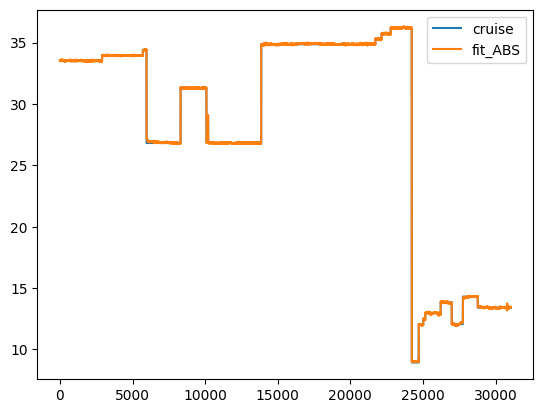

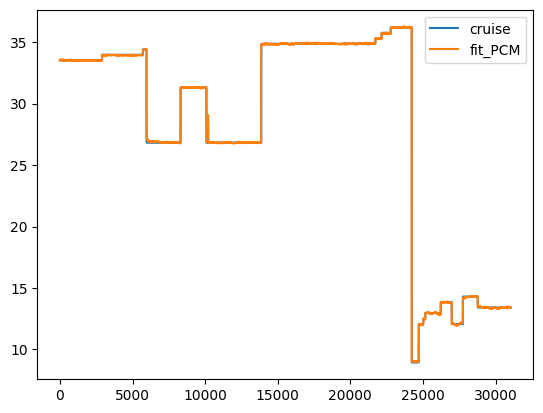

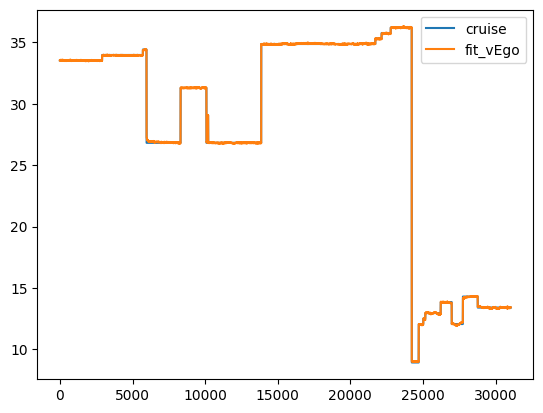

In [8]:
import numpy as np
from scipy.optimize import curve_fit


def fit(df_fit, df_test, label, y_func):
  df_test = df_test.copy()

  x_label = label
  y_label = f'fit_{label}'

  popt, pcov = curve_fit(y_func, df_fit[x_label], df_fit['cruise'])

  x_pow = len(popt) - 1
  equation = f'{y_label} = '
  for i, coef in enumerate(popt):
    equation += f'{coef}'
    if x_pow > 0:
      equation += f' * {x_label}^{x_pow}'
    if i < len(popt) - 1:
      equation += ' + '
    x_pow -= 1
  print(equation)

  df_test[y_label] = df_test[x_label].apply(lambda x: y_func(x, *popt))
  print('mean absolute error:', np.mean(np.abs(df_test['cruise'] - df_test[y_label])), 'against cruise speed')

  df_test[['cruise', y_label]].plot()


for x_label in ['ABS', 'PCM', 'vEgo']:
  print(x_label)
  fit(df_crop, df, x_label, lambda x, a, b: a * x + b)
  # fit(df_crop, df, x_label, lambda x, a: a * x + 0.277777777778)
  # fit(df_crop, df, x_label, lambda x, a: 1.035 * x + a)
  print()